In [1]:
'''
New attempt at processing data

Goals: 
- Acknowledge the existence of 2 needed corrections 
    1. DC offset 
    2. Multiplier 

Methods: 
- Use S2c data to calculate for DC offset (curve fit) 
    Curve will take the form of y = a + exp(bx), note that this is not the actual equation but rather the 2DEG 
- Subtract DC offset from raw data and and multiply values with multiplier 
    After determining the value of a, apply (S2-a)*multiplier 
    Multiplier = S2c/S2 
- Return corrected data (apply best fit which should just be the exponential term in 2DEG)
''' 


'\nNew attempt at processing data\n\nGoals: \n- Acknowledge the existence of 2 needed corrections \n    1. DC offset \n    2. Multiplier \n\nMethods: \n- Use S2c data to calculate for DC offset (curve fit) \n    Curve will take the form of y = a + exp(bx), note that this is not the actual equation but rather the 2DEG \n- Subtract DC offset from raw data and and multiply values with multiplier \n    After determining the value of a, apply (S2-a)*multiplier \n    Multiplier = S2c/S2 \n- Return corrected data (apply best fit which should just be the exponential term in 2DEG)\n'

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import os
import os.path
from scipy.optimize import curve_fit

In [3]:
# Loading file, and obtaining long name components 
path = "./testfolder"
data_list = os.listdir(path) # Create a list of all files in the folder

current_file = data_list[2]
print(f"The file being used is {current_file}.")
components = current_file.split("_")
latticeT = components[0]

The file being used is 174_p200_n1_x_100_10nm_IT_10.csv.


In [4]:
# Constants to be used 
h = 4.1357 * 10 ** -15 # Plancks constant in eV*s
c = 2.99792458 * 10 ** 8 # Speed of light in m/s 
k = 8.617333262145 * 10 ** -5 # Boltzmann constant in eV/K
comp = 0.939162 # Composition for InGaAs, estimated by Peter, solved through Wolfram Alpha 

# User input 
wl = 1550*10**-9 # in m, wavelength of LED light
T = float(latticeT) + 273.15 # Lattice temperature, K 
bandE = 0.42+0.625*comp*(5.8/(T+300)-4.19/(T+271))*10**-4 * T**2 * comp - (4.19*10**-4 * T**2)/(T+271) + 0.475*comp**2 # in eV, bandgap energy for InGaAs. 
print(f"The band gap energy is {bandE}")


The band gap energy is 0.7435616030790153


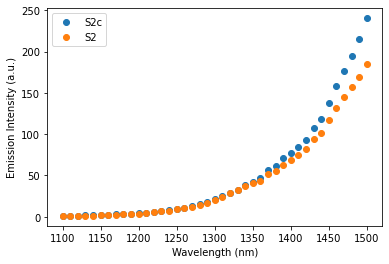

In [5]:
# Plot of raw S2c data to be used for ML
test_df = pd.read_csv(path+f"/{data_list[2]}") # For future uses, we will be doing 'for' loop for the entire directory, so there won't be a need to selectively choose the index 
col = test_df.columns # out: Index(['Wavelength', 'S2c', 'Wavelength.1', 'S2'], dtype='object')

# Creating new df to not mess with original 
new_df = pd.DataFrame() 
new_df[col[0]] = test_df[col[0]].iloc[1:] # Wavelength, using iloc to remove non numerical value 
new_df[col[1]] = test_df[col[1]].iloc[1:] # S2c 
new_df[col[3]] = test_df[col[3]].iloc[1:] # S2
new_df = new_df.astype(float) # Converting data values to numeric from strings, prep for parse in plot

# Introducing first correction factor, from dlambda to dE 
scale1 = 1240
new_df[col[1]] = new_df[col[1]] * scale1 # First correction S2c 
new_df[col[3]] = new_df[col[3]] * scale1 # First correction S2 

# Plot of raw S2c and S2 
plt.plot(new_df[col[0]], new_df[col[1]], 'o', label='S2c') # note that -o can be used to connect the dots 
plt.plot(new_df[col[0]], new_df[col[3]], 'o', label='S2')
plt.legend()
plt.ylabel('Emission Intensity (a.u.)')
plt.xlabel('Wavelength (nm)')
#plt.savefig('s2c+s2.png')
plt.show() 



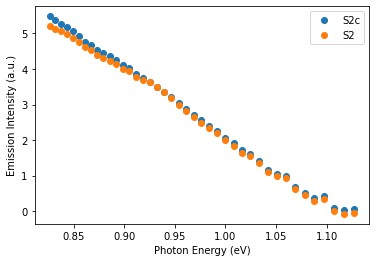

In [6]:
# Converting raw S2c to semi log plot of emission intensity against photon energy  (manually log data)
new_df['Photon Energy'] = (h*c)/(new_df[col[0]]*10**-9)#*1000/38.94 
new_df['ln(S2c)'] = np.log(new_df[col[1]])
new_df['ln(S2)'] = np.log(new_df[col[3]])
plt.plot(new_df['Photon Energy'], new_df['ln(S2c)'], 'o', label='S2c')
plt.plot(new_df['Photon Energy'], new_df['ln(S2)'], 'o', label='S2')
plt.ylabel('Emission Intensity (a.u.)')
plt.xlabel('Photon Energy (eV)')
plt.legend()
plt.show()

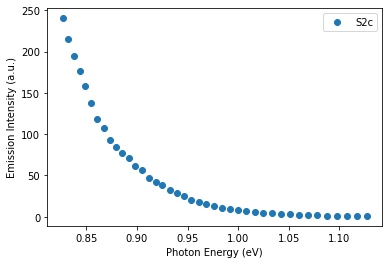

In [7]:
plt.plot(new_df['Photon Energy'], new_df['S2c'], 'o', label='S2c')
plt.ylabel('Emission Intensity (a.u.)')
plt.xlabel('Photon Energy (eV)')
plt.legend()
plt.show()

[5.21094017e-02 1.93101141e+01 2.05486123e+09]
[[2.64817216e-01 7.16941032e-02 1.20911857e+08]
 [7.16941032e-02 3.88378684e-02 6.66028520e+07]
 [1.20911857e+08 6.66028520e+07 1.14297083e+17]]


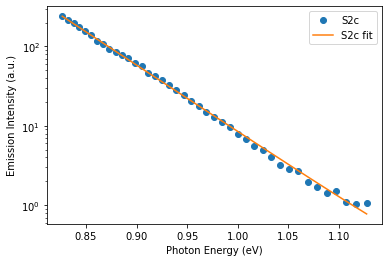

In [17]:
def exp_fit(E, a, b, c): 
    # return  a + c * E * np.sqrt(E - bandE) * np.exp(-E/0.046)# Eg and k are already defined previously 
    return a + c  * np.exp(-E*b)

E = np.linspace(np.min(new_df['Photon Energy']), np.max(new_df['Photon Energy']),1000)

popt, pcov = curve_fit(exp_fit, new_df['Photon Energy'], new_df['S2c'],maxfev = 10000, p0=[0,500/23,1e+8]) # keep c = 1e+8
print(popt)
print(pcov)
plt.plot(new_df['Photon Energy'], new_df['S2c'], 'o', label='S2c')
plt.plot(new_df['Photon Energy'], exp_fit(new_df['Photon Energy'], *popt), '-', label='S2c fit')
plt.ylabel('Emission Intensity (a.u.)')
plt.xlabel('Photon Energy (eV)')
plt.yscale('log')
plt.legend()
plt.savefig('fit.png')
plt.show()